<a href="https://colab.research.google.com/github/anthonytmh/lavis-pnpvqa/blob/pnp_vqa/projects/pnp-vqa/pnp_vqa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PNP-VQA: Inference Demo

In [ ]:
# install requirements
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !git clone https://github.com/salesforce/LAVIS
    %cd LAVIS
    !pip install .

In [1]:
import torch
import requests
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from lavis.common.gradcam import getAttMap
from lavis.models import load_model_and_preprocess

### Load an example image and question

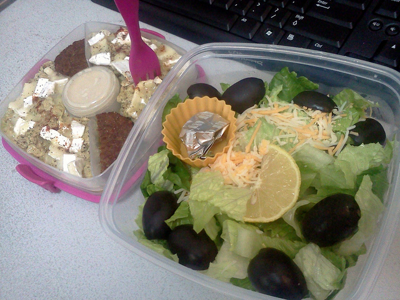

What is the black objects on the salad called?


In [2]:
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/LAVIS/projects/pnp-vqa/demo.png' 
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')   
# raw_image = Image.open("./demo.png").convert("RGB")
display(raw_image.resize((400, 300)))
question = "What is the black objects on the salad called?"
print(question)

In [3]:
# setup device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load PNP-VQA model

In [4]:
model, vis_processors, txt_processors = load_model_and_preprocess(name="pnp_vqa", model_type="base", is_eval=True, device=device)

### Preprocess image and text inputs

In [5]:
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
question = txt_processors["eval"](question)

samples = {"image": image, "text_input": [question]}

### PNP-VQA utilizes 3 submodels to perform VQA:
#### 1. Image-Question Matching 
Compute the relevancy score of image patches with respect to the question using GradCAM

In [6]:
samples = model.forward_itm(samples=samples)

Question: what is the black objects on the salad called?


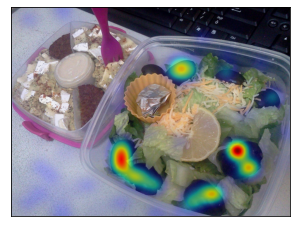

In [7]:
# Gradcam visualisation
dst_w = 720
w, h = raw_image.size
scaling_factor = dst_w / w

resized_img = raw_image.resize((int(w * scaling_factor), int(h * scaling_factor)))
norm_img = np.float32(resized_img) / 255
gradcam = samples['gradcams'].reshape(24,24)

avg_gradcam = getAttMap(norm_img, gradcam, blur=True)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(avg_gradcam)
ax.set_yticks([])
ax.set_xticks([])
print('Question: {}'.format(question))

#### 2. Image Captioning
Generate question-guided captions based on the relevancy score

In [8]:
samples = model.forward_cap(samples=samples, num_captions=50, num_patches=20)
print('Examples of question-guided captions: ')
samples['captions'][0][:5]

Examples of question-guided captions: 


['salad salad black close salad salad olive side salad salad a salad salad salad salad salad',
 'a plastic container and a salad and a plastic spoon',
 'olive olive black salad black olive salad olive olive black black olive black black olive olive',
 'a dish loaded with olives and olives',
 'there is a black olive salad in black olives']

#### 3. Question Answering
Answer the question by using the captions

In [9]:
pred_answers = model.forward_qa(samples, num_captions=50)
print('Question: {} \nPredicted answer: {}'.format(question, pred_answers[0]))

Question: what is the black objects on the salad called? 
Predicted answer: olives


### Generate answer by calling `predict_answers()` directly


In [10]:
pred_answers = model.predict_answers(samples, num_captions=50, num_patches=20)
print('Question: {} \nPredicted answer: {}'.format(question, pred_answers[0]))

Question: what is the black objects on the salad called? 
Predicted answer: ['olives']
